# 0. Introduction

This notebook contains the exercise presented for the Introduction to Data Science section of Udacity's Data Science nanodegree. The course project is called Writing a Data Scientist Blog Post and consists in answering 3 questions based on a dataset selected by the student. The findings need to be presented as a blog post.

I have picked the following Kaggle competition dataset: House Prices - Advanced Regression Techniques. Predict sales prices and practice feature engineering, RFs, and gradient boosting. The project is described on kaggle's website as follows:

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

# 1. Dataset exploration

The competition includes 2 different datasets named train.csv and test.csv. The test dataset doesn't include the price column. The predictions for the test dataset need to be submitted to kaggle in order to obtain a competition score. For this project, only the train dataset will be used and it will be subdivided into train/test subsets for the modeling part of the exercise.

The following cells include a first assessment of the dataset.

In [1]:
#import all the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#load the train dataset

df = pd.read_csv('./train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df.shape

(1460, 81)

As specified in the competition description, the dataset includes 79 independent variables and a dependent variable (price). That makes a total of 81 columns including the Id. There are a total of 1460 entries.

In [4]:
df['Id'].is_unique

True

We see there are no duplicates in the Id column, so we can assume all rows are independent from each other and correspond to individual entries.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We see in the previous cell that all the columns seem to have a correct data type associated. All numerical variables are either integers or floats and the rest are categorical. We also see there are NaN values in many of the columns, which I look at in more detail in the following cells.

In [6]:
no_nulls = df.columns[df.isnull().mean()==0]
no_nulls.size

62

In [7]:
half_nulls = df.columns[df.isnull().mean() > 0.5]
half_nulls.size

4

Out of the 81 columns, 62 of them have no NaN values. 4 columns have more than 50% missing values and the rest have less than 50% NaN. From the list above I can look separately into each of them to decide what to do with the missing values.

In [8]:
df.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

For instance, the _Alley_ column has only a value assigned to the rows corresponding to houses with alleys. Houses without alley access present a NaN value. In this case I'll create a new column named _Alley_acces_ with Yes No values as this could be an important feature to consider. I will also fill the NaN of the original columns with 'No Alley' values. I will do the same for the _Fence_ column as well as for the columns referring to the garage or basement.

In [9]:
df.loc[df['Alley'] == 'Grvl', 'Has_Alley'] = 'Yes'
df.loc[df['Alley'] == 'Pave', 'Has_Alley'] = 'Yes'
df.Has_Alley.fillna('No', inplace=True)
df.Has_Alley.value_counts()

No     1369
Yes      91
Name: Has_Alley, dtype: int64

In [10]:
df.Alley.fillna('No_Alley', inplace=True)
df.Alley.value_counts()

No_Alley    1369
Grvl          50
Pave          41
Name: Alley, dtype: int64

In [11]:
df.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [12]:
df.Fence.fillna('No_Fence', inplace=True)
df.loc[df['Fence'] == 'No_Fence', 'Has_Fence'] = 'No'
df.Has_Fence.fillna('Yes', inplace=True)
df.Has_Fence.value_counts()

No     1179
Yes     281
Name: Has_Fence, dtype: int64

In [13]:
df.BsmtCond.fillna('No_Basement', inplace=True)
df.loc[df['BsmtCond'] == 'No_Basement', 'Has_Bsmt'] = 'No'

df.BsmtQual.fillna('No_Basement', inplace=True)

df.BsmtFinType1.fillna('No_Basement', inplace=True)

df.BsmtExposure.fillna('No_Basement', inplace=True)

df.BsmtFinType2.fillna('No_Basement', inplace=True)

df.Has_Bsmt.fillna('Yes', inplace=True)
df.Has_Bsmt.value_counts()

Yes    1423
No       37
Name: Has_Bsmt, dtype: int64

In [14]:
df.GarageType.fillna('No_Garage', inplace=True)
df.loc[df['GarageType'] == 'No_Garage', 'Has_Garage'] = 'No'

df.GarageYrBlt.fillna('No_Garage', inplace=True)
df.GarageFinish.fillna('No_Garage', inplace=True)
df.GarageQual.fillna('No_Garage', inplace=True)
df.GarageCond.fillna('No_Garage', inplace=True)

df.Has_Garage.fillna('Yes', inplace=True)
df.Has_Garage.value_counts()

Yes    1379
No       81
Name: Has_Garage, dtype: int64

Given the low number of houses with a pool in the dataset, I remove the _Pool quality_ column. The fact of containing a pool can be important, but it's already included in the PoolArea column which is kept.

I also remove the _Miscellaneous feature_ column as only 54 houses have a value in it and the listed features are very different from one another. Similarly, I'll delete the fireplace quality column as there are almost half the values missing.

In [15]:
df = df.drop(columns=['PoolQC', 'MiscFeature', 'FireplaceQu'])

I will fill the NaN values of the 8 rows in the Masonry Veneer columns, with 'None' and 0, which are values that are already included in the existing column values:

In [16]:
df.MasVnrArea.fillna(0, inplace=True)
df.MasVnrType.fillna('None', inplace=True)

For the _Electrical_ column I use the mode to fill the only row with a missing value:

In [17]:
df.Electrical.value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [18]:
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
df.Electrical.value_counts()

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Finally, for _LotFrontage_ I'll fill the missing values with the average of the column, as all the lots should have some street frontage.

In [19]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)

In [20]:
df.shape

(1460, 82)

In [21]:
no_nulls = df.columns[df.isnull().mean()==0]
no_nulls.size

82

The modified dataset contains no missing values and is ready for modeling in the next steps. But before doing that, I combine all the previous wrangling steps into a single function that could be applied to Kaggle's 'Test.csv' dataset to make it match the train set:

In [22]:
def wrangle(df):
    # Fill Alley NaNs:
    df.loc[df['Alley'] == 'Grvl', 'Has_Alley'] = 'Yes'
    df.loc[df['Alley'] == 'Pave', 'Has_Alley'] = 'Yes'
    df.Has_Alley.fillna('No', inplace=True)
    df.Alley.fillna('No_Alley', inplace=True)
    
    # Fill Fence NaNs:
    df.Fence.fillna('No_Fence', inplace=True)
    df.loc[df['Fence'] == 'No_Fence', 'Has_Fence'] = 'No'
    df.Has_Fence.fillna('Yes', inplace=True)
    
    # Fill Basement NaNs:
    df.BsmtCond.fillna('No_Basement', inplace=True)
    df.loc[df['BsmtCond'] == 'No_Basement', 'Has_Bsmt'] = 'No'
    df.BsmtQual.fillna('No_Basement', inplace=True)
    df.BsmtFinType1.fillna('No_Basement', inplace=True)
    df.BsmtExposure.fillna('No_Basement', inplace=True)
    df.BsmtFinType2.fillna('No_Basement', inplace=True)
    df.Has_Bsmt.fillna('Yes', inplace=True)
    
    # Fill Garage NaNs:
    df.GarageType.fillna('No_Garage', inplace=True)
    df.loc[df['GarageType'] == 'No_Garage', 'Has_Garage'] = 'No'
    df.GarageYrBlt.fillna('No_Garage', inplace=True)
    df.GarageFinish.fillna('No_Garage', inplace=True)
    df.GarageQual.fillna('No_Garage', inplace=True)
    df.GarageCond.fillna('No_Garage', inplace=True)
    df.Has_Garage.fillna('Yes', inplace=True)
    
    # Fill Masonry Veneer NaNs:
    df.MasVnrArea.fillna(0, inplace=True)
    df.MasVnrType.fillna('None', inplace=True)
    
    # Fill Electrical NaNs:
    df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
    
    # Fill Lot Frontage NaNs:
    df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
    
    # Drop discarded columns:
    df = df.drop(columns=['PoolQC', 'MiscFeature', 'FireplaceQu'])
    
    # Check for NaNs:
    columns = df.shape[1]
    no_null_columns = df.columns[df.isnull().mean()==0].size
    
    if columns == no_null_columns:
        print('The dataframe contains no null values and is ready for modeling.')
    else:
        print('It looks like there are still some null values in the dataset, check them out.')
        
    return df

Check the function on the reloaded dataset:

In [23]:
df2 = pd.read_csv('./train.csv')
df2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [24]:
df2_clean = wrangle(df2)

The dataframe contains no null values and is ready for modeling.


Check the function on the test dataset:

In [25]:
df3 = pd.read_csv('./test.csv')
df3_clean = wrangle(df3)

It looks like there are still some null values in the dataset, check them out.


In [26]:
df3_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

We see the test dataset still contains many columns after applying the wrangle function. The number of missing values is very low compared to the original dataset, around 2-3 values per row. These can be filled with the mode for the categorical functions and with the mean for the numerical functions. These lines of code are added to the wrangle function:

In [27]:
def wrangle(df):
    # Fill Alley NaNs:
    df.loc[df['Alley'] == 'Grvl', 'Has_Alley'] = 'Yes'
    df.loc[df['Alley'] == 'Pave', 'Has_Alley'] = 'Yes'
    df.Has_Alley.fillna('No', inplace=True)
    df.Alley.fillna('No_Alley', inplace=True)
    
    # Fill Fence NaNs:
    df.Fence.fillna('No_Fence', inplace=True)
    df.loc[df['Fence'] == 'No_Fence', 'Has_Fence'] = 'No'
    df.Has_Fence.fillna('Yes', inplace=True)
    
    # Fill Basement NaNs:
    df.BsmtCond.fillna('No_Basement', inplace=True)
    df.loc[df['BsmtCond'] == 'No_Basement', 'Has_Bsmt'] = 'No'
    df.BsmtQual.fillna('No_Basement', inplace=True)
    df.BsmtFinType1.fillna('No_Basement', inplace=True)
    df.BsmtExposure.fillna('No_Basement', inplace=True)
    df.BsmtFinType2.fillna('No_Basement', inplace=True)
    df.Has_Bsmt.fillna('Yes', inplace=True)
    
    # Fill Garage NaNs:
    df.GarageType.fillna('No_Garage', inplace=True)
    df.loc[df['GarageType'] == 'No_Garage', 'Has_Garage'] = 'No'
    df.GarageYrBlt.fillna('No_Garage', inplace=True)
    df.GarageFinish.fillna('No_Garage', inplace=True)
    df.GarageQual.fillna('No_Garage', inplace=True)
    df.GarageCond.fillna('No_Garage', inplace=True)
    df.Has_Garage.fillna('Yes', inplace=True)
    
    # Fill Masonry Veneer NaNs:
    df.MasVnrArea.fillna(0, inplace=True)
    df.MasVnrType.fillna('None', inplace=True)
    
    # Fill Electrical NaNs:
    df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
    
    # Fill Lot Frontage NaNs:
    df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True)
    
    # Drop discarded columns:
    df = df.drop(columns=['PoolQC', 'MiscFeature', 'FireplaceQu'])
    
    # Fill the remaining NaNs:
    missing_columns = df.columns[df.isna().any()].tolist()
    for column in missing_columns:
        if df[column].dtype == 'float64':
            df[column].fillna(df[column].mean(), inplace=True)
        elif df[column].dtype == 'int64':
            df[column].fillna(df[column].mean(), inplace=True)
        else:
            df[column].fillna(df[column].mode()[0], inplace=True)
    
        
    # Check for NaNs:
    columns = df.shape[1]
    no_null_columns = df.columns[df.isnull().mean()==0].size
        
    if columns == no_null_columns:
        print('The dataframe contains no null values and is ready for modeling.')
    else:
        print('It looks like there are still some null values in the dataset, check them out.')
        
    return df

Check the new function on both datasets:

In [28]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [29]:
df_train_clean = wrangle(df_train)

The dataframe contains no null values and is ready for modeling.


In [30]:
df_test_clean = wrangle(df_test)

The dataframe contains no null values and is ready for modeling.


# 2. Business Questions

After a first assessment of the dataset I would like to answer the following questions:

A. Does the dataset reflect the financial crisis of 2007-2008. Did it have a significant impact on the price of the houses sold during and after that period?

B. How well can we predict prices based on all the features contained in the dataset?

C. What are the top 5 features in terms of impact weight on the house price? How well can we predict prices based only on these 5 features?

## Question A

In [71]:
df_train_clean.YrSold.value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

The dataset includes houses sold between 2006 and 2010. I compare the price per sqft for all those years to see if it peaked at 2007/2008:

In [72]:
df = df_train_clean

In [82]:
df['price_sqft'] = df['SalePrice'] / df['GrLivArea']

In [92]:
df.price_sqft.mean()

120.57287807326834

In [91]:
df2 = df['price_sqft'].groupby(df['YrSold']).mean()
df2

YrSold
2006    119.854862
2007    121.609500
2008    121.347008
2009    119.473571
2010    120.690814
Name: price_sqft, dtype: float64

In [93]:
df2 = df['SalePrice'].groupby(df['YrSold']).mean()
df2

YrSold
2006    182549.458599
2007    186063.151976
2008    177360.838816
2009    179432.103550
2010    177393.674286
Name: SalePrice, dtype: float64

In [33]:
df2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Has_Alley,Has_Fence,Has_Bsmt,Has_Garage
0,1,60,RL,65.0,8450,Pave,No_Alley,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,No,No,Yes,Yes
1,2,20,RL,80.0,9600,Pave,No_Alley,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,No,No,Yes,Yes
2,3,60,RL,68.0,11250,Pave,No_Alley,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,No,No,Yes,Yes
3,4,70,RL,60.0,9550,Pave,No_Alley,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,No,No,Yes,Yes
4,5,60,RL,84.0,14260,Pave,No_Alley,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,No,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,No_Alley,Reg,Lvl,AllPub,...,0,8,2007,WD,Normal,175000,No,No,Yes,Yes
1456,1457,20,RL,85.0,13175,Pave,No_Alley,Reg,Lvl,AllPub,...,0,2,2010,WD,Normal,210000,No,Yes,Yes,Yes
1457,1458,70,RL,66.0,9042,Pave,No_Alley,Reg,Lvl,AllPub,...,2500,5,2010,WD,Normal,266500,No,Yes,Yes,Yes
1458,1459,20,RL,68.0,9717,Pave,No_Alley,Reg,Lvl,AllPub,...,0,4,2010,WD,Normal,142125,No,No,Yes,Yes


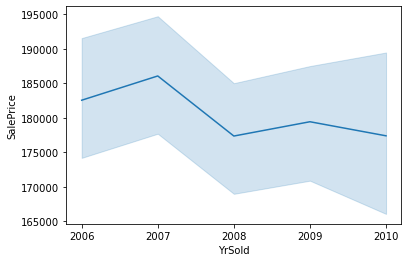

In [59]:
sns.lineplot(data=df2, x="YrSold", y="SalePrice")
years = df2['YrSold'].unique()
years.sort()
plt.xticks(years);

In [57]:
years = df2['YrSold'].unique()
years.sort()
years

array([2006, 2007, 2008, 2009, 2010], dtype=int64)